# Messing around with Prophet

## Set up

In [1]:
import pandas as pd
from prophet import Prophet

In [14]:
# Importing the dataset
df = pd.read_csv('data/recruited_daily.csv')
df.head()

,date,Patients Recruited
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


## Preprocessing

In [6]:
# Change dates to datetime objects
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date                  datetime64[ns]
Patients Recruited             int64
dtype: object

In [7]:
# Rename column names to 'ds' for the dates and 'y' for the values.
# This is for use with prophet
df.columns = ['ds', 'y']

df.head()

,ds,y
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


In [8]:
# resampling dates as monthly aggregates
df_monthly = df.set_index('ds').resample('M').sum()
df_monthly = df_monthly.reset_index()

df_monthly.head()

,ds,y
0,2021-01-31,14
1,2021-02-28,11
2,2021-03-31,16
3,2021-04-30,13
4,2021-05-31,10


## Forecasting

In [9]:
# Train the model
m = Prophet(interval_width=0.95)
model = m.fit(df)

19:18:06 - cmdstanpy - INFO - Chain [1] start processing
19:18:06 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Creating the future dates to forcast
future_dates = model.make_future_dataframe(periods=12, freq='M')
future_dates.head()

,ds
0,2021-01-07
1,2021-01-10
2,2021-01-11
3,2021-01-12
4,2021-02-11


In [11]:
# Forecasting output
forecast = m.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-07,2.828397,-2.021493,10.781242,2.828397,2.828397,1.571477,1.571477,1.571477,1.571477,1.571477,1.571477,0.0,0.0,0.0,4.399874
1,2021-01-10,2.849663,-4.016330,8.891162,2.849663,2.849663,-0.157505,-0.157505,-0.157505,-0.157505,-0.157505,-0.157505,0.0,0.0,0.0,2.692158
2,2021-01-11,2.856752,-3.868124,9.414103,2.856752,2.856752,-0.079085,-0.079085,-0.079085,-0.079085,-0.079085,-0.079085,0.0,0.0,0.0,2.777667
3,2021-01-12,2.863841,-3.677802,9.732409,2.863841,2.863841,0.536667,0.536667,0.536667,0.536667,0.536667,0.536667,0.0,0.0,0.0,3.400508
4,2021-02-11,3.076503,-1.724631,11.187532,3.076503,3.076503,1.571477,1.571477,1.571477,1.571477,1.571477,1.571477,0.0,0.0,0.0,4.647979


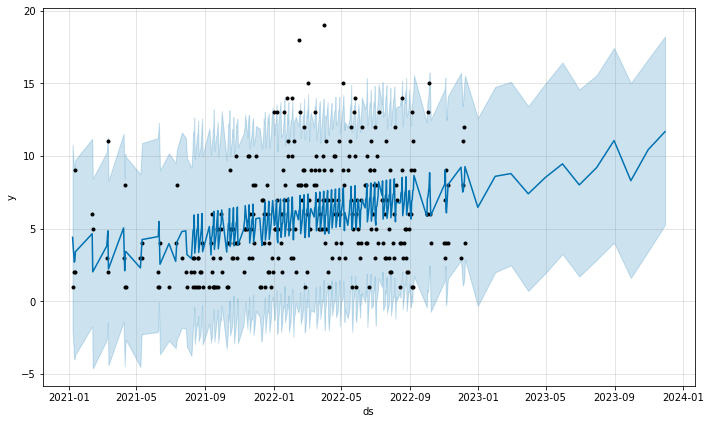

In [12]:
# Forecast plot
plot1 = m.plot(forecast)

In [13]:
# # forecasting with monthly dataframe

# # Fit model
# m = Prophet(interval_width=0.95)
# model2 = m.fit(df_monthly)

# # Creating the future dates
# future_dates2 = model.make_future_dataframe(periods=12, freq='M')
# future_dates2.head()

# # Forecasting output
# forecast = m.predict(future_dates2)

# # Forecast plot
# plot2 = m.plot(forecast)

Some notes about what Prophet is doing: <br>
You'll note that I've made no attempt at making the data stationary before shoving it into a model, but apparently the model that prophet is using isn't concerned with stationarity... <br>
*"No. Stationarity is an important condition for some other time series forecasting algorithms such as ARMA or ARIMA, but prophet assumes nothing about stationarity. Prophet rather makes use of features like trend or seasonality, which stationary data by definition do not have"*
<br><br>
I'll probably want to learn how to intepret the plot and dataframe that prophet has output above, next.
...

# To-do:
- Organisee notebook, change variable name such that the table that I've copied in has the same name as the table that the data is from in the original notebook.
- Create a train-test spilt for cross validation.
- Compare predictions with actual values
- Then forecast for a prediction in the future.
- Make some commments about the 95 confidence interval.


Things to understand:
- What is an additive model
- what are the alternatives to prophet and why choose them instead of prophet or vice versa.
- Why doesn't prophet require preprocessing?
- How to use the holidays feature of prophet 